# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 Basic statistics :

Users :

In [8]:
users_ratings = data.map(lambda x: (x['userId'], x['rating']))
users_counts = users_ratings.countByKey().items()

Movies

In [9]:
movies_ratings = data.map(lambda x: (x['movieId'], x['rating']))
movies_counts = movies_ratings.countByKey().items()

Now let's plot :

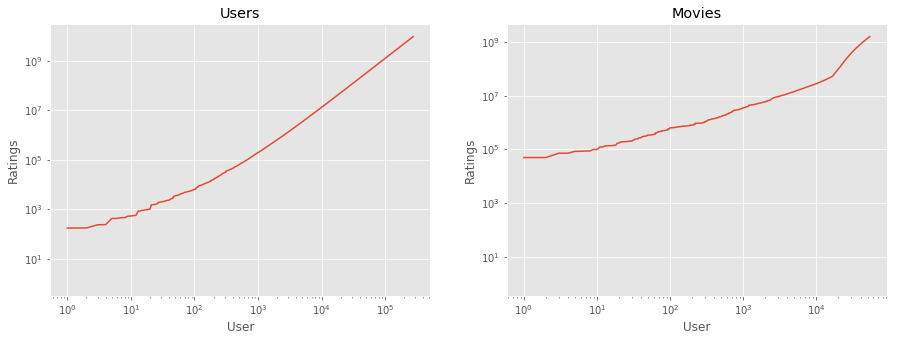

In [20]:
cumulative_users = np.cumsum(sorted(list(users_counts)))
cumulative_movies = np.cumsum(sorted(list(movies_counts)))

fig, (axe1, axe2) = plt.subplots(ncols=2, figsize=(15, 5))
axe1.plot(cumulative_users)
axe1.set_title("Users")
axe1.set_xlabel('User')
axe1.set_ylabel('Ratings')

axe2.plot(cumulative_movies)
axe2.set_title("Movies")
axe2.set_xlabel('User')
axe2.set_ylabel('Ratings')

axe2.loglog()
axe1.loglog()

plt.show()

Some users have a lot of ratings as well as movies and users having little number of ratings. The distributions of the ratings isn't balanced uniformly.

## Exercise 3.5 Partitioning the dataset :

In [23]:
personnal_ratings = list() ## add the personnal ranking somehow
with open("my-ratings.txt") as f :
    for line in f:
        personnal_ratings.append(json.loads(line.strip()))

newData = data.union(sc.parallelize(personnal_ratings))

training = newData.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
test = newData.filter(lambda x: (x['timestamp'] % 10) <= 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))

### Baseline recommender system

#### Baseline model

In [24]:
mu = training.map(lambda x: x[2]).mean()

In [25]:
mu

3.5255073364131335

In [40]:
## find how to get all_user_bias and all_item_bias
all_user_mean = training.map(lambda x: (x[0], x[2])).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])
all_user_bias = all_user_mean.map(lambda x: (x[0], x[1]-mu))

[(14, 3.72)]


In [42]:
mean_user_bias = all_user_bias.values().mean()
mean_user_bias

0.10160805230563459

In [49]:
all_item_bias = training.map(lambda x: (x[1], x[2] - all_user_bias[x[0]] - mu)).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/pyspark/cloudpickle.py", line 235, in dump
    return Pickler.dump(self, obj)
  File "/opt/anaconda3/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/opt/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/opt/anaconda3/lib/python3.6/pickle.py", line 751, in save_tuple
    save(element)
  File "/opt/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/hdp/current/spark2-client/python/pyspark/cloudpickle.py", line 378, in save_function
    self.save_function_tuple(obj)
  File "/usr/hdp/current/spark2-client/python/pyspark/cloudpickle.py", line 529, in save_function_tuple
    save(closure_values)
  File "/opt/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/opt/anaconda3/lib/p

PicklingError: Could not serialize object: Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

In [47]:
mean_item_bias = all_item_bias.values().mean()
mean_item_bias

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 27.0 failed 4 times, most recent failure: Lost task 1.3 in stage 27.0 (TID 186, iccluster057.iccluster.epfl.ch, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/pyspark/worker.py", line 253, in main
    process()
  File "/usr/hdp/current/spark2-client/python/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 2440, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 2440, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 350, in func
    return f(iterator)
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 1859, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/hdp/current/spark2-client/python/pyspark/shuffle.py", line 237, in mergeValues
    for k, v in iterator:
  File "/usr/hdp/current/spark2-client/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-46-b929fb30501f>", line 1, in <lambda>
NameError: name 'user_biases' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:470)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:453)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:165)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/pyspark/worker.py", line 253, in main
    process()
  File "/usr/hdp/current/spark2-client/python/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 2440, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 2440, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 350, in func
    return f(iterator)
  File "/usr/hdp/current/spark2-client/python/pyspark/rdd.py", line 1859, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/hdp/current/spark2-client/python/pyspark/shuffle.py", line 237, in mergeValues
    for k, v in iterator:
  File "/usr/hdp/current/spark2-client/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-46-b929fb30501f>", line 1, in <lambda>
NameError: name 'user_biases' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:470)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:453)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
def user_bias(userId):
    if userId in all_user_bias.keys():
        return all_user_bias[userId]
    
    return ## Use mean of biases

def item_bias(movieId):
    if movieId in all_item_bias.keys():
        return all_item_bias[movieId]
    
    return ## Use mean of biases

In [ ]:
def predict(user, movie):
    return ((user, movie), mu + user_bias(user) + item_bias(movie))

#### Evaluation

In [ ]:
def error(rdd):
    ranks_and_preds = test.map(lambda x: ((x[0], x[1]), x[2])).join(rdd)
    err = ## Implement the error calculation
    
    return err

### Matrix-factorization model

In [ ]:
from pyspark.mllib.recommendation import ALS

Lower rank implies simpler model, thus a faster training. Higher rank increases the amount of parameters used in the learning process, thus the probability of overfitting increases with the rank.

In [ ]:
## Choose the rank ? (Shall we use 10 ?)
rank = 10

#### Regularization

In [ ]:
param = 10e-4
model = ALS.train(training, rank, lambda_=param)
prediction = model.predictAll("SOME DATA HERE").map(lambda x: ((x[0], x[1]), x[2]))


error = error(prediction)
print('Error with lambda=10^-4: ', error)

param2 = 10.0
model2 = ALS.train(training, rank, lambda_=param2)
prediction2 = model.predictAll("SOME DATA HERE").map(lambda x: ((x[0], x[1]), x[2]))


error2 = error(prediction)
print('Error with lambda=10.0: ', error2)

In [ ]:
## Find optimal lambda below
optimal_lambda = VALUE

#### Recommendation

In [ ]:
model = ALS.train("DATA", rank=10, lambda_=optimal_lambda)

movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
ids_to_title = movies.map(itemgetter("movieId", "title")).collectAsMap()

In [ ]:
## Do the recommendation for both users

#### Visualisation

In [ ]:
new_model = ALS.train(training, rank=2, lambda_=optimal_lambda)
selected_movies = sorted(pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8'))

In [ ]:
• Create an interactive plot that embeds the movies along the 2 directions defined by the
factorization.
• Describe what you observe. Can you give a name to the dimensions? Do you recognize
cluster of movies that are alike?